# Simple LSTM models for discretized ACTS data

In this notebook we will test out some of our LSTM models for discrete 3D data on some recent ACTS data.

Some things to try:
- Next-layer prediction for a single track
- Seeded single track hit assignment with backgrounds

In [1]:
from __future__ import print_function

# System imports
import ast
import os

# GPU selection
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Data handling
import numpy as np
import pandas as pd

# Machine learning
from keras import layers, models

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Local imports
from metrics import calc_hit_accuracy
from drawing import draw_projections
from drawing import draw_3d_event

%matplotlib notebook

Using TensorFlow backend.


## Data utilities

In [2]:
def load_data_events(file_name, columns, print_freq=100):
    """
    Load data from file into a dataframe.
    This function will detect each event and adds an evtid column.
    """
    dfs = []
    print('Loading', file_name)
    with open(file_name) as f:
        event_lines = []
        # Loop over lines in the file
        for line in f:
            # Add to current event
            if line.strip() and line[0] != '#':
                event_lines.append(ast.literal_eval(line))
            
            # Finalize a complete event
            elif len(event_lines) > 0:
                evtid = len(dfs)
                if (evtid % print_freq) == 0:
                    print('Finished event', evtid)
                df = pd.DataFrame(event_lines)
                df.columns = columns
                df['evtid'] = evtid
                dfs.append(df)
                event_lines = []
        # Verify there are no leftovers (otherwise fix this code)
        assert len(event_lines) == 0
    
    # Concatenate the events together into one DataFrame
    return pd.concat(dfs, ignore_index=True)

def process_hits_data(df, copy_keys=['evtid', 'hitid', 'barcode', 'volid', 'layid']):
    """Split columns and calculate some derived variables"""
    hits = pd.DataFrame(df[copy_keys])
    x = df.gpos.apply(lambda pos: pos[0])
    y = df.gpos.apply(lambda pos: pos[1])
    #hits['x'] = x
    #hits['y'] = y
    hits['z'] = df.gpos.apply(lambda pos: pos[2])
    hits['r'] = np.sqrt(x**2 + y**2)
    hits['phi'] = np.arctan2(y, x)
    #hits['theta'] = np.arctan2(hits.r, hits.z)
    #hits['eta'] = -1. * np.log(np.tan(hits.theta / 2.))
    return hits

def process_particles_data(df, copy_keys=['evtid', 'barcode', 'q']):
    """Split columns and calculate some derived variables"""
    particles = pd.DataFrame(df[copy_keys])
    #particles['vx'] = df.vpos.apply(lambda pos: pos[0])
    #particles['vy'] = df.vpos.apply(lambda pos: pos[1])
    #particles['vz'] = df.vpos.apply(lambda pos: pos[2])
    particles['p'] = df.kin.apply(lambda kin: kin[0])
    theta = df.kin.apply(lambda kin: kin[1])
    #particles['theta'] = theta
    particles['phi'] = df.kin.apply(lambda kin: kin[2])
    particles['pt'] = particles.p * np.sin(theta)
    particles['eta'] = -1. * np.log(np.tan(theta / 2.))
    return particles

#def hits2barhist(hits, layer_bins=10, phi_bins=32, z_bins=32):
#    """Converts a hits dataframe into a 3D barrel detector histogram"""
#    # Need to convert vol+lay ids into a layer index. Use a table join.
#    vlid_table = pd.DataFrame(
#        [[8,2,0], [8,4,1], [8,6,2], [8,8,3],
#         [13,2,4], [13,4,5], [13,6,6], [13,8,7],
#         [17,2,8], [17,4,9]],
#        columns=['volid', 'layid', 'layer'])
#    coords = hits.merge(vlid_table, on=['volid', 'layid'])[['layer', 'phi', 'z']]
#    layer_range = [0, 10]
#    phi_range = [-np.pi, np.pi]
#    z_range = [-1100, 1100]
#    return np.histogramdd(coords.values, bins=[layer_bins, phi_bins, z_bins],
#                          range=[layer_range, phi_range, z_range])[0]

## Read the data

In [3]:
# Input file path(s)
hits_file_name = '/bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_1.csv'
particles_file_name = '/bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/particles_1.csv'

#hits_file_name = '/bigdata/shared/ACTS/prod_mu200_pt500_2017_07_25/clusters_1.csv'
#particles_file_name = '/bigdata/shared/ACTS/prod_mu200_pt500_2017_07_25/particles_1.csv'

#hits_file_name = '/home/sfarrell/trackml/data/andi-testds-2017-07-13/Clusters.csv'
#particles_file_name = '/home/sfarrell/trackml/data/andi-testds-2017-07-13/Particles.csv'

In [4]:
# Read and prepare the hits data
hits_columns = ['hitid', 'barcode', 'volid', 'layid',
                'lpos', 'lerr', 'gpos',
                'chans', 'dir', 'direrr']

hits = process_hits_data(
    load_data_events(hits_file_name, columns=hits_columns))

#hits_full = load_data_events(hits_file_name, columns=hits_columns)
#hits = process_hits_data(hits_full)

Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_1.csv
Finished event 0
Finished event 100
Finished event 200
Finished event 300
Finished event 400
Finished event 500
Finished event 600
Finished event 700
Finished event 800
Finished event 900


In [5]:
# Read and prepare the particles data
particles_columns = ['barcode', 'vpos', 'kin', 'q']
particles = process_particles_data(
    load_data_events(particles_file_name, columns=particles_columns))

#particles_full = load_data_events(particles_file_name, columns=particles_columns)
#particles = process_particles_data(particles_full)

Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/particles_1.csv
Finished event 0
Finished event 100
Finished event 200
Finished event 300
Finished event 400
Finished event 500
Finished event 600
Finished event 700
Finished event 800
Finished event 900


In [6]:
print('Processed hits data shape:', hits.shape)
print('First 5 entries:')
hits.head()

Processed hits data shape: (520540, 8)
First 5 entries:


,evtid,hitid,barcode,volid,layid,z,r,phi
0,0,1,9013658885554176,7,4,-1098.0,166.043501,3.078679
1,0,2,9013658885554176,7,6,-958.0,144.459613,3.084836
2,0,3,9013658885554176,7,8,-818.0,122.856991,3.090712
3,0,4,9013658885554176,7,10,-698.0,104.329886,3.096112
4,0,5,9013658885554176,7,12,-597.5,88.815381,3.100499


In [7]:
print('Processed particle data shape:', particles.shape)
print('First few entries:')
particles.head()

Processed particle data shape: (42734, 7)
First few entries:


,evtid,barcode,q,p,phi,pt,eta
0,0,9007611571601408,-1,2.25170,2.944980,1.767035,-0.724688
1,0,9008298766368768,-1,5.85017,0.361795,1.762806,-1.869197
2,0,9009879314333696,-1,4.45530,1.373470,1.027682,2.146361
3,0,9010085472763904,1,4.50735,0.290055,1.970573,1.468907
4,0,9010154192240640,-1,3.63076,-0.198506,1.063708,1.898644


In [12]:
# Select particles in the barrel region (mostly)
eta_cut = 1.5
bar_particles = particles[np.abs(particles.eta) < eta_cut]
num_particles = bar_particles.shape[0]
print('Number of selected particles with |eta| < %g: %g' % (eta_cut, num_particles))

Number of selected particles with |eta| < 1.5: 22122


## Next-layer predictor

Let's try a simple model which predicts where the hit is going to be on the next layer, given the sequence of hits leading up to it.

In [138]:
def build_model_1(length, dim, hidden_dim=128,
                  loss='categorical_crossentropy', final_activation='softmax',
                  optimizer='Nadam', metrics=['accuracy']):
    inputs = layers.Input(shape=(length, dim))
    hidden = layers.LSTM(output_dim=hidden_dim, return_sequences=True)(inputs)
    outputs = layers.TimeDistributed(layers.Dense(dim, activation=final_activation))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

### Bin the track hits

In [13]:
# Data binning config
layer_bins, layer_range = 10, (0, 10)
phi_bins, phi_range = 16, (-np.pi, np.pi)
z_bins, z_range = 16, (-1100, 1100)

# Bin the hits data
hists = np.zeros((num_particles, layer_bins, phi_bins, z_bins))

# Convert volume+layer IDs into a single layer index, using -1 for unwanted hits
layer = pd.Series(-1, index=hits.index)
for i, (vid, lid) in enumerate([(8,2), (8,4), (8,6), (8,8),
                                (13,2), (13,4), (13,6), (13,8),
                                (17,2), (17,4)]):
    layer[(hits.volid == vid) & (hits.layid == lid)] = i

# Fill the histograms with the particle coordinates
for i in np.arange(num_particles):
    par = bar_particles.iloc[i]
    par_hits = hits[(hits.evtid == par.evtid) & (hits.barcode == par.barcode)]
    par_layers = layer[par_hits.index]
    hists[i] = np.histogramdd((par_layers, par_hits.phi, par_hits.z),
                              bins=(layer_bins, phi_bins, z_bins),
                              range=(layer_range, phi_range, z_range))[0]

#for i in np.arange(num_particles):
#    par = bar_particles.iloc[i]
#    par_hits = hits[(hits.evtid == par.evtid) & (hits.barcode == par.barcode)]
#    hists[i] = hits2barhist(par_hits, layer_bins=layer_bins,
#                            phi_bins=phi_bins, z_bins=z_bins)

print(hists.shape)

In [20]:
# Prepare model input/output
train1_input = hists[:,:-1].reshape((hists.shape[0], hists.shape[1] - 1, -1))
train1_target = hists[:,1:].reshape((hists.shape[0], hists.shape[1] - 1, -1))
train1_target[train1_target > 1] = 1

print('Input shape:', train1_input.shape)
print('Target shape:', train1_target.shape)

Input shape: (22122, 9, 256)
Target shape: (22122, 9, 256)


In [21]:
# Model config
hidden_dim = 256

# Training config
valid_frac = 0.2
batch_size = 32
num_epoch = 10

In [22]:
model1 = build_model_1(length=layer_bins-1, dim=phi_bins*z_bins,
                       hidden_dim=hidden_dim)
model1.summary()

# Train the model
history1 = model1.fit(train1_input, train1_target, batch_size=batch_size,
                      nb_epoch=num_epoch, validation_split=valid_frac)
# Get the training set predictions
train1_pred = model1.predict(train1_input)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 9, 256)        0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 9, 256)        525312      input_1[0][0]                    
____________________________________________________________________________________________________
timedistributed_1 (TimeDistribut (None, 9, 256)        65792       lstm_1[0][0]                     
Total params: 591,104
Trainable params: 591,104
Non-trainable params: 0
____________________________________________________________________________________________________
Train on 17697 samples, validate on 4425 samples
Epoch 1/10
17697/17697 [==============================] - 11s - loss: 2

<IPython.core.display.Javascript object>


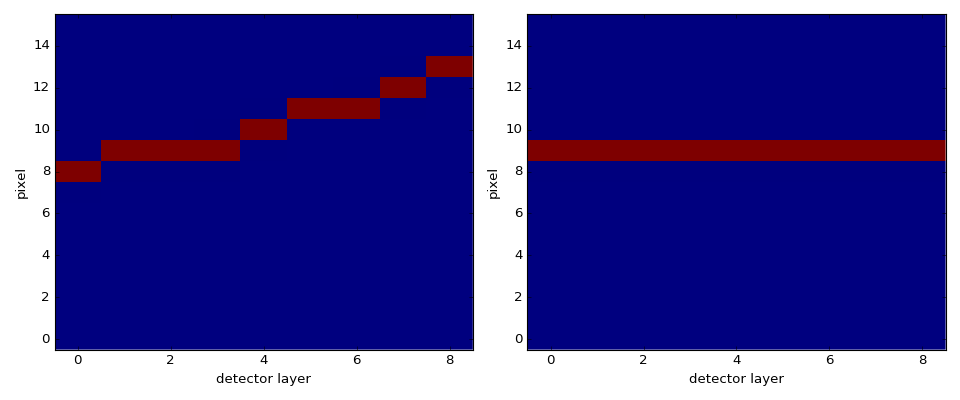

<IPython.core.display.Javascript object>


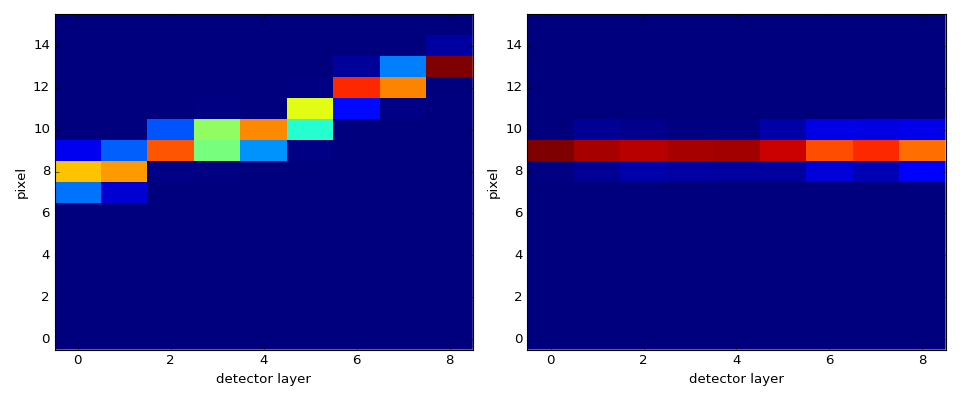

In [34]:
i = 24
draw_projections(train1_target[i].reshape((layer_bins-1, phi_bins, z_bins)));
draw_projections(train1_pred[i].reshape((layer_bins-1, phi_bins, z_bins)));

## Single-track hit assignment

In this case we want to bin all the hits in an event, and we want to do bin classification starting from a track seed.

In [103]:
# Select all barrel hits
barrel_hits = hits[(hits.volid == 8) | (hits.volid == 13) | (hits.volid == 17)]

In [9]:
# Convert volume+layer IDs into a single layer index, using -1 for unwanted hits
layer = pd.Series(-1, index=hits.index)
for i, (vid, lid) in enumerate([(8,2), (8,4), (8,6), (8,8),
                                (13,2), (13,4), (13,6), (13,8),
                                (17,2), (17,4)]):
    layer[(hits.volid == vid) & (hits.layid == lid)] = i

In [120]:
# Select target tracks that have 8 or more hits in the barrel
signal_tracks = (barrel_hits.groupby(['evtid', 'barcode'])
                 .filter(lambda x: len(x) > 8)
                 .groupby(['evtid', 'barcode']))
print(signal_tracks.ngroups)

20778


In [169]:
# Data binning config
layer_bins, layer_range = 10, (0, 10)
phi_bins, phi_range = 32, (-np.pi, np.pi)
z_bins, z_range = 32, (-1100, 1100)

# Number of seed layers
seed_size = 4

# Histogram function binning arguments
binning_args = dict(bins=(layer_bins, phi_bins, z_bins),
                    range=(layer_range, phi_range, z_range))

# Tensor shapes
nsamples = signal_tracks.ngroups
hist_shape = (layer_bins, phi_bins, z_bins)
flat_shape = (hist_shape[0], -1)

In [170]:
# Prepare the model data
signal_hists = np.zeros((nsamples,) + hist_shape)
event_hists = np.zeros((nsamples,) + hist_shape)

In [171]:
# Loop over signal track samples
isample = 0
for (evtid, pid), sig_hits in signal_tracks:
    evt_hits = barrel_hits[barrel_hits.evtid == evtid]
    sig_layers = layer[sig_hits.index]    
    evt_layers = layer[evt_hits.index]
    # Signal track histogram
    sig_hist = np.histogramdd((sig_layers, sig_hits.phi, sig_hits.z), **binning_args)[0]
    # Event histogram
    evt_hist = np.histogramdd((evt_layers, evt_hits.phi, evt_hits.z), **binning_args)[0]
    evt_hist[:seed_size] = sig_hist[:seed_size]
    sig_hist[sig_hist > 1] = 1
    event_hists[isample] = evt_hist
    signal_hists[isample] = sig_hist
    isample += 1

In [172]:
# Prepare the model input and target
train2_input = event_hists.reshape((nsamples,) + flat_shape)
train2_target = signal_hists.reshape((nsamples,) + flat_shape)

In [173]:
# Model config
hidden_dim = 128

# Training config
valid_frac = 0.2
batch_size = 32
num_epoch = 10

In [174]:
# Construct and train the model
model2 = build_model_1(length=layer_bins, dim=phi_bins*z_bins,
                       hidden_dim=hidden_dim)
model2.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 10, 1024)      0                                            
____________________________________________________________________________________________________
lstm_4 (LSTM)                    (None, 10, 128)       590336      input_4[0][0]                    
____________________________________________________________________________________________________
timedistributed_4 (TimeDistribut (None, 10, 1024)      132096      lstm_4[0][0]                     
Total params: 722,432
Trainable params: 722,432
Non-trainable params: 0
____________________________________________________________________________________________________


In [175]:
# Train the model
history2 = model2.fit(train2_input, train2_target, batch_size=batch_size,
                      nb_epoch=num_epoch, validation_split=valid_frac)

# Get the training set predictions
train2_pred = model2.predict(train2_input)

Train on 16622 samples, validate on 4156 samples
Epoch 1/10
16622/16622 [==============================] - 12s - loss: 4.1565 - acc: 0.2274 - val_loss: 2.9991 - val_acc: 0.3135
Epoch 2/10
16622/16622 [==============================] - 11s - loss: 2.5256 - acc: 0.3885 - val_loss: 2.2930 - val_acc: 0.4327
Epoch 3/10
16622/16622 [==============================] - 11s - loss: 1.8671 - acc: 0.4942 - val_loss: 1.9146 - val_acc: 0.4876
Epoch 4/10
16622/16622 [==============================] - 11s - loss: 1.4738 - acc: 0.5594 - val_loss: 1.7186 - val_acc: 0.5160
Epoch 5/10
16622/16622 [==============================] - 11s - loss: 1.2201 - acc: 0.6131 - val_loss: 1.6259 - val_acc: 0.5365
Epoch 6/10
16622/16622 [==============================] - 11s - loss: 1.0334 - acc: 0.6575 - val_loss: 1.5668 - val_acc: 0.5496
Epoch 7/10
16622/16622 [==============================] - 11s - loss: 0.8836 - acc: 0.6978 - val_loss: 1.5206 - val_acc: 0.5603
Epoch 8/10
16622/16622 [==============================]

Model input


<IPython.core.display.Javascript object>


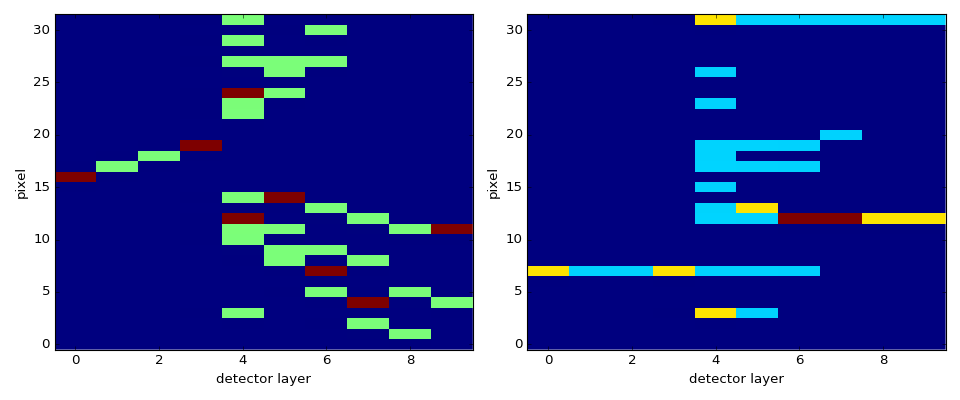

Model target


<IPython.core.display.Javascript object>


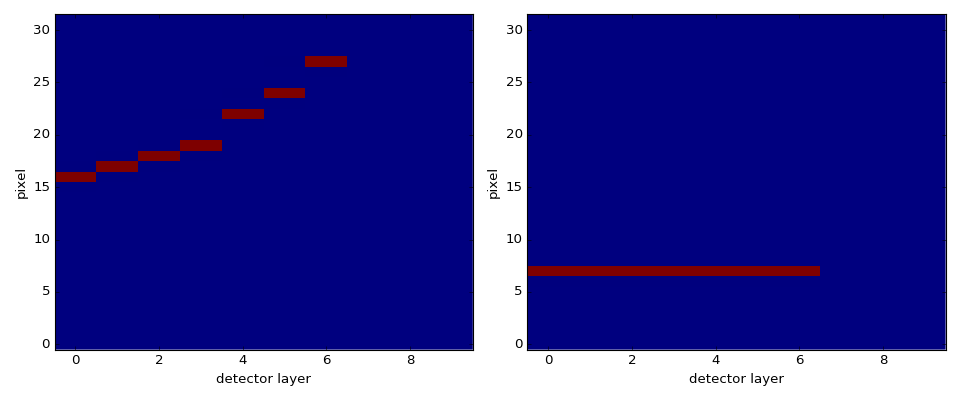

Model prediction


<IPython.core.display.Javascript object>


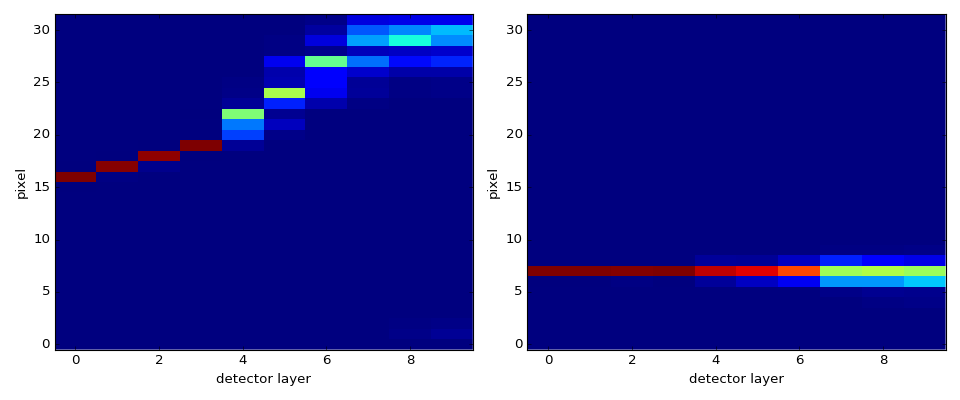

In [176]:
# Visualize predictions
i = 3
print('Model input')
draw_projections(train2_input[i].reshape(hist_shape))
print('Model target')
draw_projections(train2_target[i].reshape(hist_shape))
print('Model prediction')
draw_projections(train2_pred[i].reshape(hist_shape));

In [178]:
calc_hit_accuracy(train2_pred, train2_target, num_seed_layers=seed_size)

0.6400840632720506